In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels as sm


In [16]:
# Okay

raw_occupations ="""*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"
"""

raw_occupations = raw_occupations.replace("*", "")
raw_occupations = raw_occupations.replace("\t", "")
raw_occupations = raw_occupations.replace("\n", ",")

occupations = []
for occupation in raw_occupations.split(","):
    occupations += occupation[:occupation.rfind('"') + 1] + ","

occupations = "".join(occupations)
occupations = "{" + occupations[:occupations.rfind(',') - 1] + "}"
final_occupations = eval("dict(" + occupations + ")")
final_occupations

{0: 'other',
 1: 'academic/educator',
 2: 'artist',
 3: 'clerical/admin',
 4: 'college/grad student',
 5: 'customer service',
 6: 'doctor/health care',
 7: 'executive/managerial',
 8: 'farmer',
 9: 'homemaker',
 10: 'K-12 student',
 11: 'lawyer',
 12: 'programmer',
 13: 'retired',
 14: 'sales/marketing',
 15: 'scientist',
 16: 'self-employed',
 17: 'technician/engineer',
 18: 'tradesman/craftsman',
 19: 'unemployed',
 20: 'writer'}

In [17]:
# Aquiring
users = pd.read_csv("datasets/movielens/users.dat",
                    sep="::",
                    dtype={
                        "user_id": np.int64,
                        "sex": np.str_,
                        "age_group": np.int64,
                        "occupation": np.int64,
                        "zip_code": np.str_
                    },
                    names=["user_id", "sex", "age_group",
                           "occupation", "zip_code"],
                    index_col="user_id",
                    engine="python")
movies = pd.read_csv("datasets/movielens/movies.dat",
                     sep="::",
                     dtype={
                         "movie_id": np.int64,
                         "title": np.str_,
                         "genre": np.str_,
                     },
                     names=["movie_id", "title", "genre"],
                     index_col="movie_id",
                     engine="python")
ratings = pd.read_csv("datasets/movielens/ratings.dat",
                      sep="::",
                      dtype={
                          "user_id": np.int64,
                          "movie_id": np.int64,
                          "rating": np.int64,
                          "timestamp": np.int64,
                      },
                      names=["user_id", "movie_id", "rating", "timestamp"],
                      engine="python")

# Cleaning up

# Make timestamp into datetime
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit='s')

# Convert genre into list
movies["genre"] = movies["genre"].apply(lambda record: str(record).split('|'))

# Convert occupations to their counterpart
users["occupation"] = users["occupation"].apply(lambda occupation: final_occupations[int(occupation)])

display(users.head())
display(movies.head())
display(ratings.head())


,sex,age_group,occupation,zip_code
user_id,,,,
1,F,1,K-12 student,48067
2,M,56,self-employed,70072
3,M,25,scientist,55117
4,M,45,executive/managerial,02460
5,M,25,writer,55455


,title,genre
movie_id,,
1,Toy Story (1995),"[Animation, Children's, Comedy]"
2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
3,Grumpier Old Men (1995),"[Comedy, Romance]"
4,Waiting to Exhale (1995),"[Comedy, Drama]"
5,Father of the Bride Part II (1995),[Comedy]


,user_id,movie_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [18]:
# Method 1
def turn_list_to_rows(df):
    df = pd.DataFrame(df.iloc[0]).T

    for genre in df.iat[0, 1]:
        df = pd.concat(
            [df, pd.DataFrame({"title": [df.iat[0, 0]], "genre": [genre]})])

    df = df.reset_index(drop=True).drop(0)
    return df


unnested = movies.copy()
unnested = unnested.groupby(movies.index).apply(
    turn_list_to_rows).reset_index().drop(columns="level_1")
display(unnested.head())


,movie_id,title,genre
0,1,Toy Story (1995),Animation
1,1,Toy Story (1995),Children's
2,1,Toy Story (1995),Comedy
3,2,Jumanji (1995),Adventure
4,2,Jumanji (1995),Children's


In [19]:
# Method 2
rows_list = []

for index in movies.index:
    row = movies.loc[index]
    for genre in row.at["genre"]:
        rows_list.append(
            {
                "movie_id": index,
                "title": row.at["title"],
                "genre": genre
            }
        )
unnested = pd.DataFrame(rows_list)
display(unnested.head())


,movie_id,title,genre
0,1,Toy Story (1995),Animation
1,1,Toy Story (1995),Children's
2,1,Toy Story (1995),Comedy
3,2,Jumanji (1995),Adventure
4,2,Jumanji (1995),Children's


In [20]:
# Computing average genre ratings

# Aggregate user ratings by movie
movie_average_ratings = ratings[["movie_id", "rating"]].groupby(
    "movie_id").mean("rating")
display(movie_average_ratings.head())

# Join it with the unnested movies
unnested_with_average = pd.merge(
    unnested, movie_average_ratings, on="movie_id")
display(unnested_with_average.head())

# Get average rating by genre
result = unnested_with_average.drop(columns="title").groupby(
    "genre").agg({"movie_id": "count", "rating": "mean"})
result = result.rename(
    columns={"movie_id": "number_of_movies", "rating": "average_rating"})
genres_and_average = result.sort_values(by="average_rating", ascending=False)
display(genres_and_average)

,rating
movie_id,
1,4.146846
2,3.201141
3,3.016736
4,2.729412
5,3.006757


,movie_id,title,genre,rating
0,1,Toy Story (1995),Animation,4.146846
1,1,Toy Story (1995),Children's,4.146846
2,1,Toy Story (1995),Comedy,4.146846
3,2,Jumanji (1995),Adventure,3.201141
4,2,Jumanji (1995),Children's,3.201141


,number_of_movies,average_rating
genre,,
Film-Noir,44,3.806448
Documentary,110,3.687885
War,141,3.594314
Western,67,3.471926
Mystery,104,3.440532
Drama,1493,3.415331
Musical,113,3.388002
Crime,201,3.385133
Animation,105,3.358366


(0.0, 5.0)

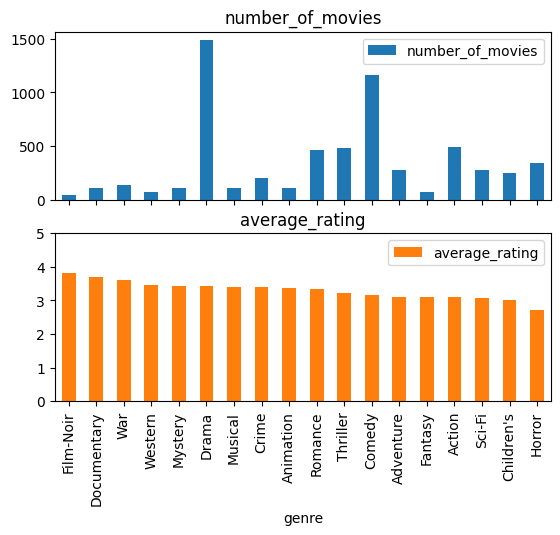

In [21]:
# Plot it
axes = genres_and_average.plot.bar(subplots=True)
axes[1].set_ylim([0, 5])


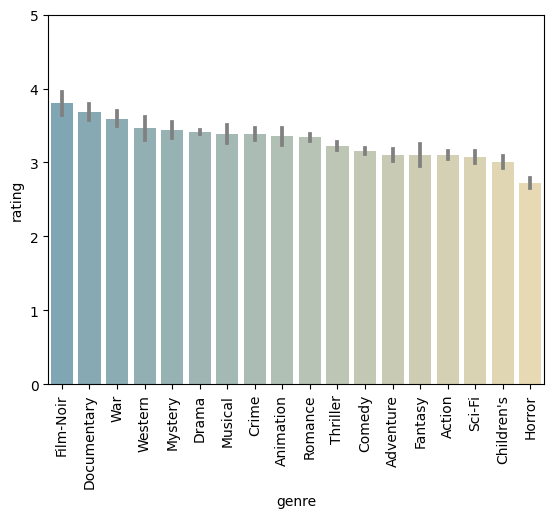

In [22]:
# Another way to visualise the confidence
axes = sns.barplot(
    data=unnested_with_average,
    x="genre",
    y="rating",
    estimator=np.mean,
    order=genres_and_average.index,
    palette="blend:#7AB,#EDA",
    errcolor="gray"
)

plt.xticks(rotation=90)
axes.set_ylim([0, 5])
plt.show()

In [41]:
# Check popular genres by occupations
ratings_and_unnested = pd.merge(
    unnested, ratings, on="movie_id"
)

all_data_unnested = pd.merge(
    ratings_and_unnested, users, on="user_id"
)

display(all_data_unnested.head())

counted = all_data_unnested.groupby(["occupation", "genre"])[["occupation", "genre", "rating"]].agg({"rating": "mean"})
counted = counted.rename(columns={"rating" : "average_rating"})
counted = counted.reset_index()
display(counted.head())

def PULA(group):
    return pd.DataFrame(group.iloc[group["average_rating"].argmax()]).T.drop(columns="occupation")
     
counted.groupby("occupation").apply(PULA).reset_index().drop(columns="level_1").set_index("occupation")

,movie_id,title,genre,user_id,rating,timestamp,sex,age_group,occupation,zip_code
0,1,Toy Story (1995),Animation,1,5,2001-01-06 23:37:48,F,1,K-12 student,48067
1,1,Toy Story (1995),Children's,1,5,2001-01-06 23:37:48,F,1,K-12 student,48067
2,1,Toy Story (1995),Comedy,1,5,2001-01-06 23:37:48,F,1,K-12 student,48067
3,48,Pocahontas (1995),Animation,1,5,2001-01-06 23:39:11,F,1,K-12 student,48067
4,48,Pocahontas (1995),Children's,1,5,2001-01-06 23:39:11,F,1,K-12 student,48067


,occupation,genre,average_rating
0,K-12 student,Action,3.497116
1,K-12 student,Adventure,3.425658
2,K-12 student,Animation,3.463956
3,K-12 student,Children's,3.220679
4,K-12 student,Comedy,3.497200


,genre,average_rating
occupation,,
K-12 student,Film-Noir,4.212766
academic/educator,Film-Noir,4.082613
artist,Film-Noir,4.114
clerical/admin,Film-Noir,4.075332
college/grad student,Film-Noir,4.039548
customer service,Film-Noir,4.027356
doctor/health care,Documentary,4.013245
executive/managerial,Film-Noir,4.030027
farmer,Documentary,3.9


In [24]:
# Let's check ratings out
print("Average rating:")
display(ratings["rating"].mean())


Average rating:


3.581564453029317